# Visualization of cancer in SHARE's 8th wave

### Cancer

In the SHARE survey, cancer is defined as follow:

*"Has a doctor ever told you that you had/ Do you currently have cancer or malignant tumour, including leukaemia or lymphoma, but excluding minor skin cancers?"*.

### Visualization

The aim of this page is to visually explore the relationship between the cancer variable and other variables, in particular non-physical health variables such as demographics, feelings, mental health and habits.

### Get code

At [CIERI Analytics](https://www.cieri-analytics.com/), we focus on the reproducibility of our work. Want to explore this work further? Download the code by clicking <a href='cancer-visualization.ipynb'>here</a>.

## Packages

In [205]:
import time
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from plotly.offline import plot

# modelling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

## Functions

I define here a few functions in order to make the code easier to read.

In [206]:
def kde_data(data):
    density = stats.gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 200)
    ys = density(xs)*100
    return xs, ys

def encode_and_scale(X):
    # encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_categorical = pd.get_dummies(X[categorical_cols],
                                    columns = categorical_cols,
                                    drop_first = True)

    # scale numerical columns
    numeric_cols = X.select_dtypes(include=['float']).columns
    X_numerical = X[numeric_cols]
    X_numerical = (X_numerical-X_numerical.mean()) / X_numerical.std()

    # merge dfs
    X = pd.concat([X_categorical, X_numerical], axis=1)
    X = X.astype(float)
    return X

def compare_models(metric, metric_name, labels):
    
    #sort by metric
    metric, labels = zip(*sorted(zip(metric, labels)))
    
    #plot
    plt.figure(figsize=(10,5))
    plt.bar(labels, metric)
    plt.ylabel(metric_name)
    plt.xticks(rotation=30)
    plt.show()

def split_fit_predict(X, y, model=LogisticRegression(max_iter=1000), threshold=0.5, random_state=0, verbose=False):
    
    if verbose:
        print("Model:", type(model).__name__)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # train model
    model.fit(X_train, y_train)
    
    # prediction
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    preds = (preds > threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, preds)
    rec = recall_score(y_test, preds)
    pre = precision_score(y_test, preds)

    if verbose:
        print(f"Accuracy: {(acc*100):.2f}%")
        print(f"AUC: {(roc):.4f}")
        print(f"Recall: {(rec):.4f}")
        print(f"Precision: {(pre):.4f}")
        print()
    
    # output
    return acc, roc, rec, pre

## Data cleaning

This cell opens and cleans the dataset.

In [207]:

br = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_br.dta')
dn = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_dn.dta')
ph = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_ph.dta')
mh = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_mh.dta')

# drop variables
for df in [br, dn, ph, mh]:
    cols_to_drop = ['hhid8', 'mergeidp8', 'coupleid8']
    if df is not mh:
        cols_to_drop = ['hhid8', 'mergeidp8', 'coupleid8', 'country', 'language']
    df.drop(cols_to_drop, axis=1, inplace=True)

merged_dataframe = pd.merge(br, dn, on = 'mergeid')
merged_dataframe = pd.merge(merged_dataframe, ph, on = 'mergeid')
merged_dataframe = pd.merge(merged_dataframe, mh, on = 'mergeid')

#print([col for col in merged_dataframe.columns if col.startswith('ph')])
df = merged_dataframe[['dn014_', 'dn042_', 'dn003_', 'language',
                       'br001_', 'br015_', 'br016_', 'br039_',
                       'ph003_', 'ph084_', 'ph006d10', 'ph012_',
                       'ph013_', 'ph041_', 'ph745_', 'country',
                       'mh002_', 'mh003_', 'mh004_', 'mh005_',
                       'mh007_', 'mh008_', 'mh010_', 'mh011_',
                       'mh013_', 'mh015_', 'mh016_', 'mh017_'
                    ]]


df.rename(columns={
    'language': 'Language',
    'country': 'Country',
    'dn014_': 'MaritalStatus',
    'dn042_': 'Gender',
    'dn003_': 'YearOfBirth',
    'br001_': 'Smoking',
    'br015_': 'SportFrequencyVigorous',
    'br016_': 'SportFrequencyModerate',
    'br039_': 'Alcool',
    'ph003_': 'HealthSelfPerception',
    'ph084_': 'Pain',
    'ph006d10': 'Cancer',
    'ph012_': 'Weight',
    'ph013_': 'Height',
    'ph041_': 'Glasses',
    'ph745_': 'HearingAid',
    'mh002_': 'Depression',
    'mh003_': 'Hopelessness',
    'mh004_': 'WishDeath',
    'mh005_': 'Guilt',
    'mh007_': 'SleepTrouble',
    'mh008_': 'Interest',
    'mh010_': 'Irritable',
    'mh011_': 'Appetite',
    'mh013_': 'Fatigue',
    'mh015_': 'ConcentrationReading',
    'mh016_': 'Enjoyment',
    'mh017_': 'Tears',
    },
    inplace=True)

values_to_replace = ["Don't know", "Refusal",
                     "Implausible value/suspected wrong", 
                     "Not codable", "Not answered",
                     "Not yet coded", "Not applicable"]
df.replace(values_to_replace, float('NaN'), inplace=True)

column_types = {
    'YearOfBirth': 'float',
    'MaritalStatus': 'category',
    'Gender': 'category',
    'Smoking': 'category',
    'SportFrequencyVigorous': 'category',
    'SportFrequencyModerate': 'category',
    'HealthSelfPerception': 'category',
    'Pain': 'category',
    'Cancer': 'category',
    'Weight': 'float',
    'Height': 'float',
    'Glasses': 'category',
    'HearingAid': 'category',
    'Depression': 'category',
    'Hopelessness': 'category',
    'WishDeath': 'category',
    'Guilt': 'category',
    'SleepTrouble': 'category',
    'Interest': 'category',
    'Irritable': 'category',
    'Appetite': 'category',
    'Fatigue': 'category',
    'ConcentrationReading': 'category',
    'Enjoyment': 'category',
    'Tears': 'category',
}
df = df.astype(column_types)

df['Age'] = 2021 - df['YearOfBirth']
df.drop(['YearOfBirth'], axis=1, inplace=True)
categorical_columns = df.select_dtypes(include=['category']).columns
for col in categorical_columns:
    df[col].cat.add_categories('Unknown').fillna('Unknown', inplace=True)

# last modifications
df = df.loc[df.Cancer != 'Unknown',]
df = df.loc[df.Age >= 50,]
df.to_csv('../../data/br_dn_ph_wave8.csv', index=False)

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_14587/694659875.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_14587/694659875.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Cancer

In [208]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')
print(df.Cancer.value_counts()/len(df)*100)

# split in cancer and no cancer
df_c = df.loc[df['Cancer']=='Selected', ]
df_nc = df.loc[df['Cancer']=='Not selected', ]

Cancer
Not selected    94.374812
Selected         5.324720
Name: count, dtype: float64


## Age distribution for people with and without cancer

In [209]:
# compute density
xs_c, ys_c = kde_data(df_c['Age'])
xs_nc, ys_nc = kde_data(df_nc['Age'])

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs_c, y=ys_c, mode='lines', name='Selected', fill='tozeroy', 
                         line_color='red', opacity=0.5))
fig.add_trace(go.Scatter(x=xs_nc, y=ys_nc, mode='lines', name='Not Selected', fill='tozeroy', 
                         line_color='blue', opacity=0.5))

# Update layout
fig.update_layout(
    title='Age Distribution split by Cancer',
    xaxis_title='Age',
    yaxis_title='Density',
    yaxis=dict(showticklabels=False),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=20, r=20, t=20, b=20),
    width=1000,
    height=600,
    plot_bgcolor='white'
)

# Update axes to remove certain spines
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showgrid=False, zeroline=False, showline=False)
#fig.show()

# save figure
plot(fig, filename="../../img/plotly/age_distribution_cancer.html")

# print t test for age
stats.ttest_ind(df_c['Age'], df_nc['Age'])

TtestResult(statistic=12.386002514662943, pvalue=3.536744554793488e-35, df=46452.0)

<iframe src="../../img/plotly/age_distribution_cancer.html" width="800" height="600"></iframe>

## Cancer rate per category

In [210]:
df.Country.unique()

array(['Austria', 'Bulgaria', 'Belgium', 'Cyprus', 'Czech Republic',
       'Switzerland', 'Germany', 'Denmark', 'Estonia', 'Spain', 'France',
       'Finland', 'Greece', 'Croatia', 'Hungary', 'Italy', 'Israel',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Romania', 'Sweden', 'Slovenia', 'Slovakia'],
      dtype=object)

You can download geographical data used for this chart at [Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/).

In [211]:
# world map
world = gpd.read_file('../../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

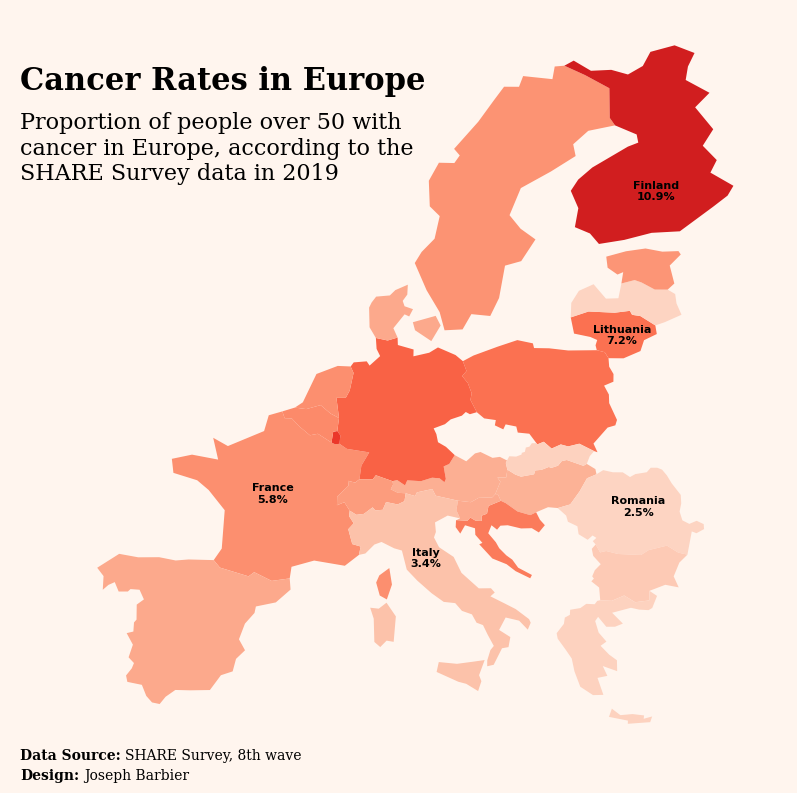

In [220]:
# define wave to year mapping
wave_to_year = {
    1: 2004,
    2: 2006,
    3: 2008,
    4: 2011,
    5: 2013,
    6: 2015,
    7: 2017,
    8: 2019
}

# colors
cmap = cm.Reds
r_cmap = cm.Reds.reversed()
min_rate, max_rate = 0, 15
norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)
col = 'seashell'

# pre-processing
def get_cancer_rates(wave):
    
    # open datasets
    path_ph = f'../../../SHARE/data/sharew{wave}_rel8-0-0_ALL_datasets_stata/sharew{wave}_rel8-0-0_ph.dta'
    path_dn = f'../../../SHARE/data/sharew{wave}_rel8-0-0_ALL_datasets_stata/sharew{wave}_rel8-0-0_dn.dta'
    ph = pd.read_stata(path_ph)
    dn = pd.read_stata(path_dn)
    dn.drop(['country'], axis=1, inplace=True)
    df = pd.merge(ph, dn, on='mergeid')
    columns = ['ph006d10', 'country', 'dn003_']
    df = df[columns]
    df.rename(columns={'ph006d10': 'Cancer',
                    'dn003_': 'YearOfBirth',
                    'country': 'Country'},
                    inplace=True)

    # deal with NaN
    values_to_replace = ["Don't know", "Refusal",
                     "Implausible value/suspected wrong", 
                     "Not codable", "Not answered",
                     "Not yet coded", "Not applicable"]
    df.replace(values_to_replace, float('NaN'), inplace=True)

    # create age variable and filter
    df['YearOfBirth'] = df['YearOfBirth'].astype(float)
    year = wave_to_year[wave]
    df["Age"] = year - df["YearOfBirth"]
    df = df.loc[df.Age >= 50,]

    # change cancer variable to binary
    df.dropna(subset=['Cancer'], inplace=True)
    df['Cancer'] = df['Cancer'].replace({'Selected': 1, 'Not selected': 0})
    df['Cancer'] = df['Cancer'].astype(int)
    
    # compute cancer rates
    cancer_rates = df.groupby('Country', observed=True)['Cancer'].mean()
    return cancer_rates

def convert_to_geojson(cancer_rates):
    europe = world[world['CONTINENT'] == 'Europe']
    europe = europe.merge(cancer_rates, how='left', left_on='NAME', right_on='Country')
    europe.dropna(subset=['Cancer'], inplace=True)
    europe['Cancer'] = round(europe['Cancer']*100,1)
    return europe

def plot_map(data, wave, col=col, cmap=cmap, norm=norm):
    
    # axis properties
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.set_xlim(-15, 35)
    ax.set_ylim(32, 72)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

    # annotations
    year = wave_to_year[wave]
    fig.text(0.26, 0.8, 'Cancer Rates in Europe', fontsize=22, fontweight='bold', fontfamily='serif')
    fig.text(0.26, 0.71, f'Proportion of people over 50 with \ncancer in Europe, according to the \nSHARE Survey data in {year}',
             fontsize=16, fontweight='light', fontfamily='serif')
    fig.text(0.26, 0.13, 'Data Source:', fontsize=10, fontweight='bold', fontfamily='serif')
    fig.text(0.33, 0.13, f'SHARE Survey, {wave}th wave', fontsize=10, fontweight='light', fontfamily='serif')
    fig.text(0.26, 0.11, 'Design:', fontsize=10, fontweight='bold', fontfamily='serif')
    fig.text(0.303, 0.11, 'Joseph Barbier', fontsize=10, fontweight='light', fontfamily='serif')
    
    # background
    ax.set_facecolor(col)
    fig.set_facecolor(col)
    
    # compute centroids for annotations
    data_projected = data.to_crs(epsg=3035)
    data_projected['centroid'] = data_projected.geometry.centroid
    data['centroid'] = data_projected['centroid'].to_crs(data.crs)
    countries_to_annotate = ['France', 'Italy', 'Romania',
                             'Lithuania', 'Finland']
    adjustments = {
        'France': (9, 3),  
        'Italy': (-1, 0),
        'Lithuania': (0, -1),
        'Finland': (0, -2.5),
        'Romania': (0, -0.5)
    }

    # plot map
    data.plot(column='Cancer', ax=ax, cmap=cmap, norm=norm)
    
    # annotate countries
    for country in countries_to_annotate:
        centroid = data.loc[data['NAME'] == country, 'centroid']
        centroid = centroid.values[0]
        x, y = centroid.coords[0]
        x += adjustments[country][0]
        y += adjustments[country][1]
        rate = data.loc[data['NAME'] == country, 'Cancer'].values[0]
        ax.annotate(f'{country}\n{rate}%', (x, y), textcoords="offset points", xytext=(5,5),
                    ha='center', fontsize=8, fontfamily='DejaVu Sans', fontweight='bold', color='black')

    #plt.show()
    fig.savefig(f'../../img/graph/map_cancer_rates_europe_wave{wave}.png', dpi=300, bbox_inches='tight')

wave = 8
cancer_rates = get_cancer_rates(wave)
cancer_rates_map = convert_to_geojson(cancer_rates)
plot_map(cancer_rates_map, wave)
    

<br>

## Modelling cancer with machine learning

In [213]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')
df['Cancer'] = df['Cancer'].replace({'Selected': 1, 'Not selected': 0})
df.dropna(subset=['Cancer'], inplace=True)
df.dropna(subset=['Weight'], inplace=True)
target = 'Cancer'
y = df[target]
df.drop([target, 'Height'], axis=1, inplace=True)
X = encode_and_scale(df)


In [214]:
X.isna().sum().sum()

0

Model: LogisticRegression
Accuracy: 66.87%
AUC: 0.6707
Recall: 0.6729
Precision: 0.0996

Model: RandomForestClassifier
Accuracy: 64.31%
AUC: 0.6588
Recall: 0.6763
Precision: 0.0931

Model: AdaBoostClassifier
Accuracy: 67.17%
AUC: 0.6739
Recall: 0.6763
Precision: 0.1008

Model: GradientBoostingClassifier
Accuracy: 66.55%
AUC: 0.6811
Recall: 0.6985
Precision: 0.1016

Model: DecisionTreeClassifier
Accuracy: 56.80%
AUC: 0.5822
Recall: 0.5980
Precision: 0.0699

Model: SVC
Accuracy: 66.96%
AUC: 0.6792
Recall: 0.6899
Precision: 0.1018

Model: KNeighborsClassifier
Accuracy: 60.94%
AUC: 0.5943
Recall: 0.5775
Precision: 0.0749

Model: MLPClassifier
Accuracy: 62.04%
AUC: 0.6154
Recall: 0.6099
Precision: 0.0806

Model: BaggingClassifier
Accuracy: 66.98%
AUC: 0.6286
Recall: 0.5826
Precision: 0.0889



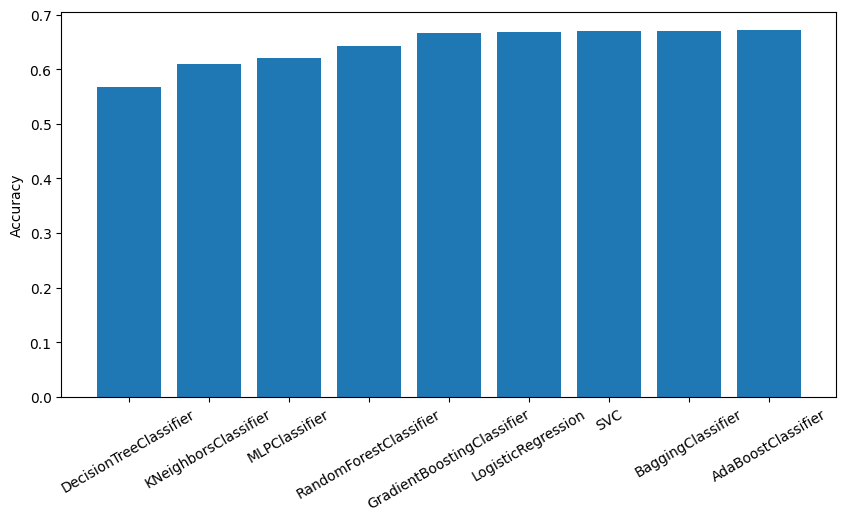

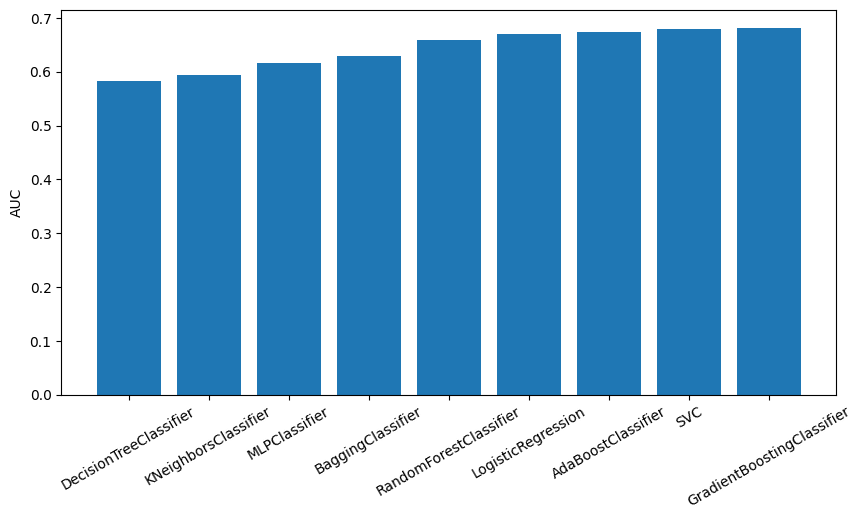

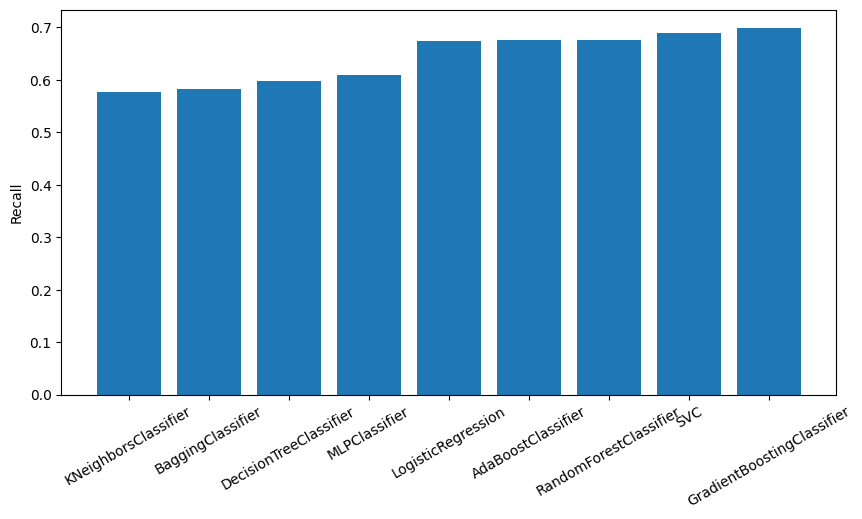

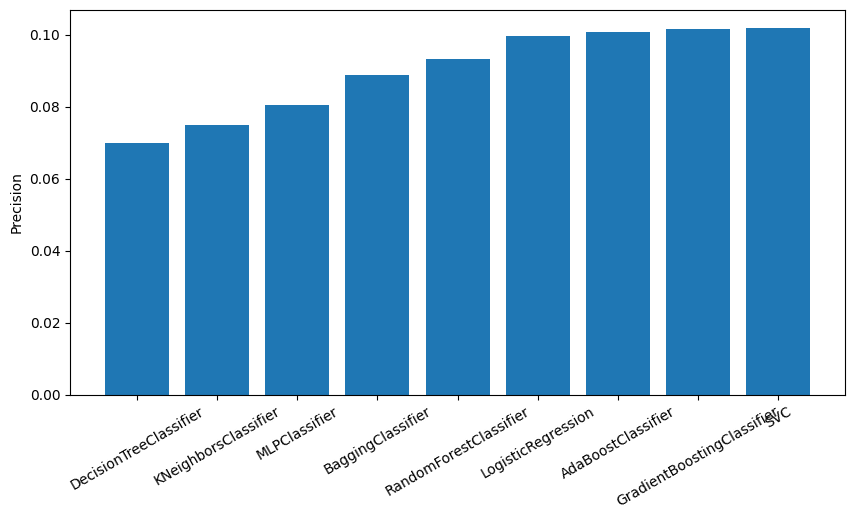

In [215]:
# fit model
accs = []
rocs = []
recs = []
pres = []
labels = []
models = [LogisticRegression(max_iter=1000),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            DecisionTreeClassifier(),
            SVC(probability=True),
            KNeighborsClassifier(),
            MLPClassifier(max_iter=1000),
            BaggingClassifier()]
for model in models:
    labels.append(type(model).__name__)
    acc, roc, rec, pre = split_fit_predict(X, y, model=model, random_state=0, verbose=True)
    accs.append(acc)
    rocs.append(roc)
    recs.append(rec)
    pres.append(pre)

# plot results
compare_models(accs, 'Accuracy', labels)
compare_models(rocs, 'AUC', labels)
compare_models(recs, 'Recall', labels)
compare_models(pres, 'Precision', labels)